## Exploratory Analysis

In [1]:
# Import Preprocessed Data
import pandas as pd
import matplotlib.pyplot as plt

clinical_data = pd.read_csv("preprocessed_clinical_data.csv")
gene_expression_data = pd.read_csv("preprocessed_gene_expression.csv", index_col=0)
methylation_data = pd.read_csv("preprocessed_methylation_data.csv", index_col=0)

In [2]:
import numpy as np

### Gene Expression

#### PCA

In [3]:
X = gene_expression_data.T

In [4]:
from sklearn.decomposition import PCA

# Keep top 2 components for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

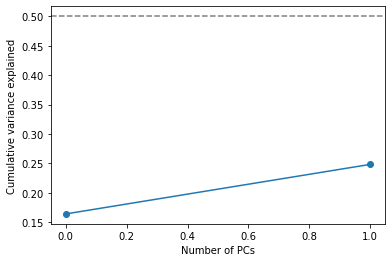

In [5]:
var_ratios = pca.explained_variance_ratio_
plt.plot(np.cumsum(var_ratios), marker='o')
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative variance explained");
plt.axhline(0.5, color='gray', linestyle='--')  # e.g. half the variance
plt.show()


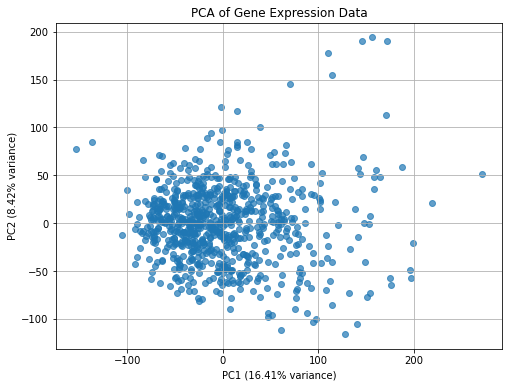

In [6]:
# PCA Visualization
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.title("PCA of Gene Expression Data")
plt.grid(True)
plt.show()

In [7]:
import seaborn as sns

In [8]:
clinical_vars = ["sample_type.samples", "disease_type", "primary_diagnosis.diagnoses", "ajcc_pathologic_t.diagnoses", "ajcc_pathologic_n.diagnoses", "ajcc_pathologic_m.diagnoses"]

                        PC1        PC2
sample                                
TCGA-AQ-A0Y5-01A   7.044025  -4.441785
TCGA-EW-A2FW-01A  19.663534   8.132179
TCGA-C8-A274-01A  29.867334 -32.026215
TCGA-B6-A0IK-01A  -6.456275 -18.418785
TCGA-E2-A1L7-01A   4.955653 -31.038108
...                     ...        ...
TCGA-E9-A1R2-01A   1.719771 -10.782930
TCGA-E2-A1IG-01A  27.038781  19.563481
TCGA-AR-A2LE-01A  15.705269  20.189819
TCGA-E2-A1IO-01A  -3.851920  10.070754
TCGA-S3-AA11-01A  24.357199 -12.015312

[766 rows x 2 columns]


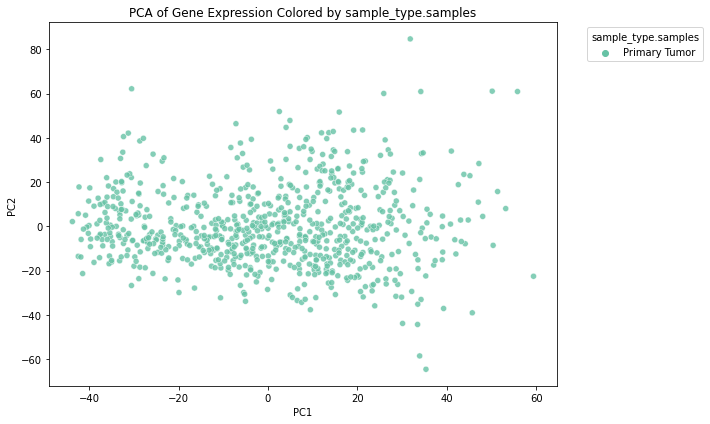

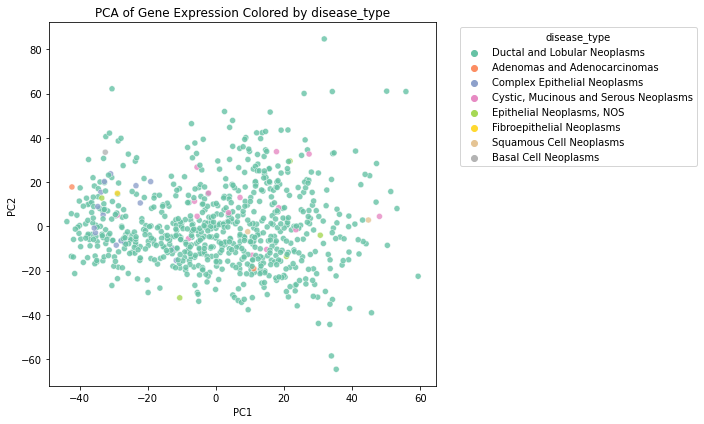

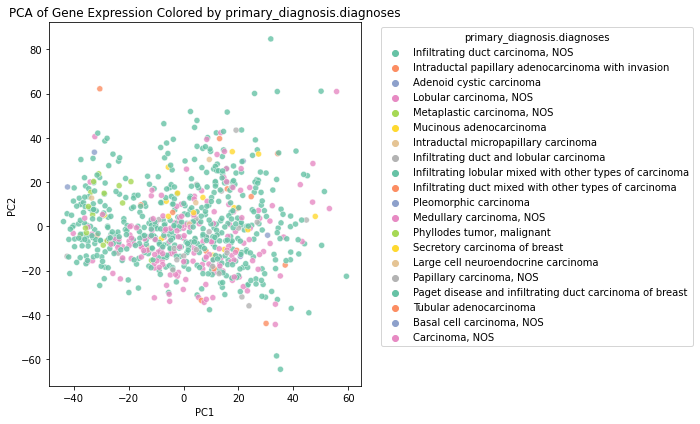

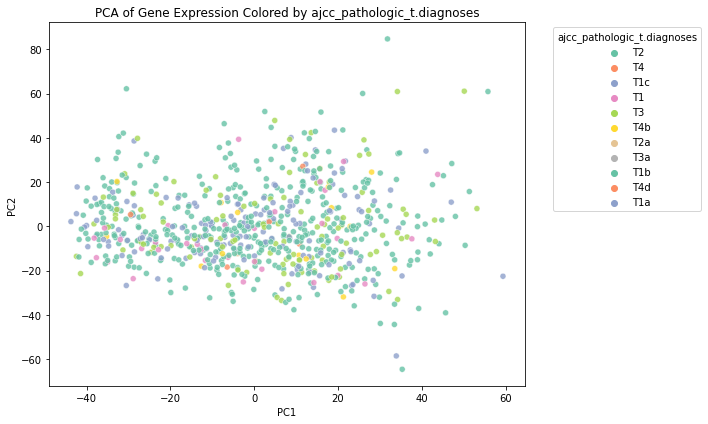

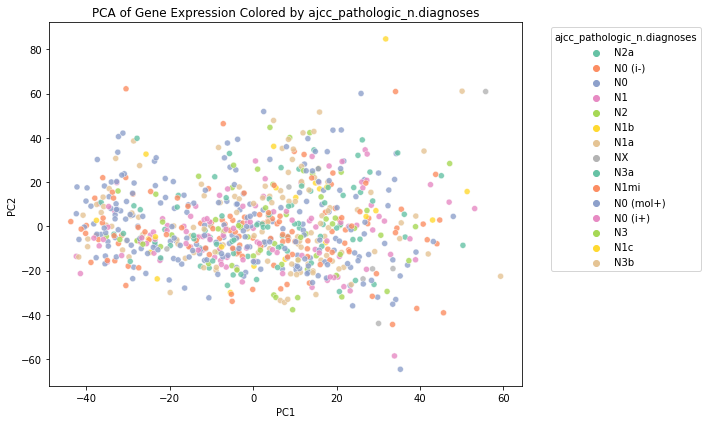

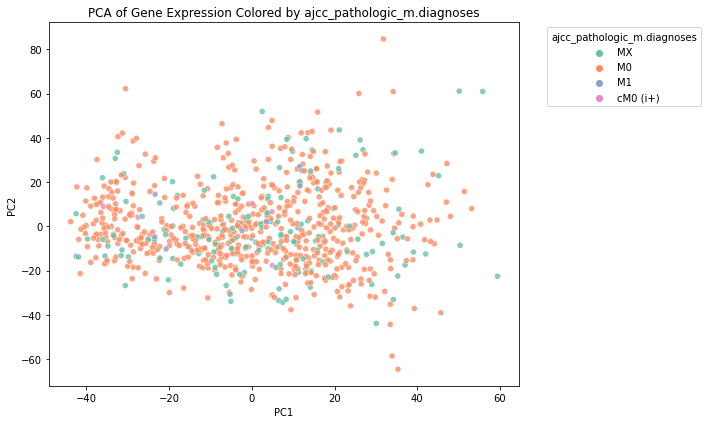

In [25]:
# Turn result into a DataFrame with sample IDs
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=X.index)
pca_df.index.name = 'sample'
print(pca_df)

# Input: clinical variable column name as string
def plot_pca_by_clinical(pca_df, clinical_var):
    clinical_data_pca = clinical_data[['sample', clinical_var]].copy()

    # Merge on sample IDs
    pca_merged = pca_df.merge(clinical_data_pca, left_index=True, right_on='sample')
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=pca_merged,
        x='PC1', y='PC2',
        hue=clinical_var,
        palette='Set2',
        alpha=0.8
    )
    plt.title(f'PCA of Gene Expression Colored by {clinical_var}')
    plt.legend(title=clinical_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for v in clinical_vars:
    plot_pca_by_clinical(pca_df, v)

#### t-SNE

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random', random_state=10)
tsne_result = tsne.fit_transform(X)

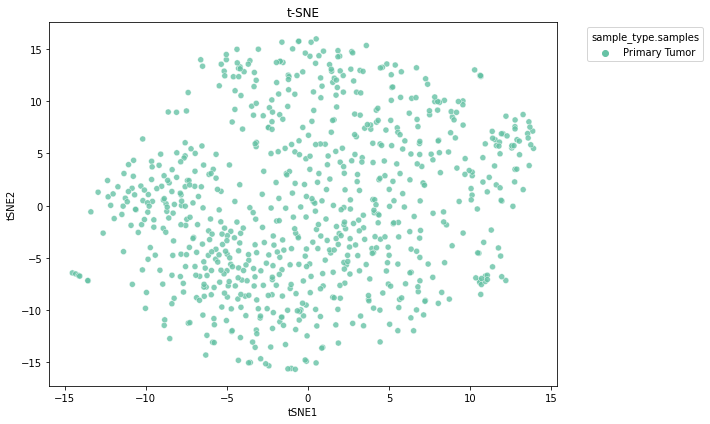

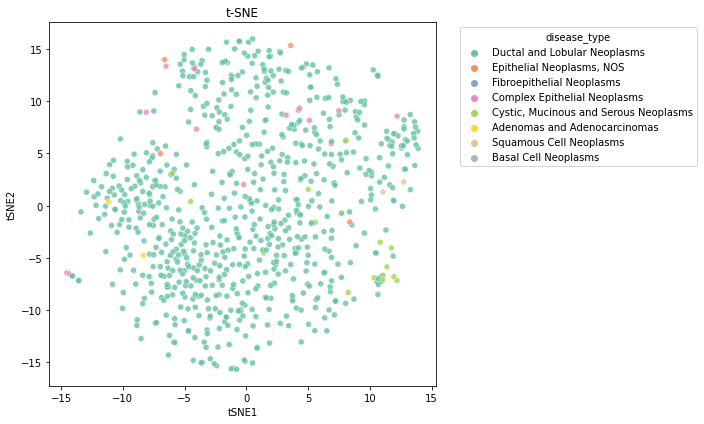

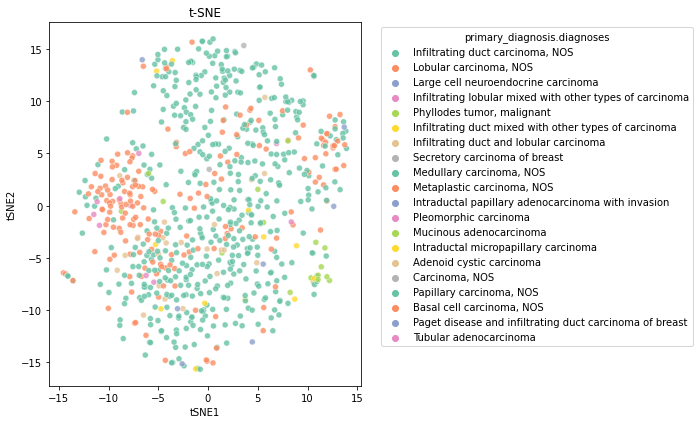

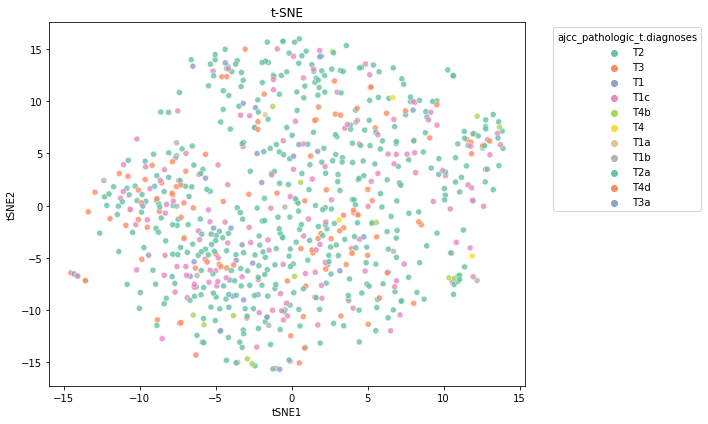

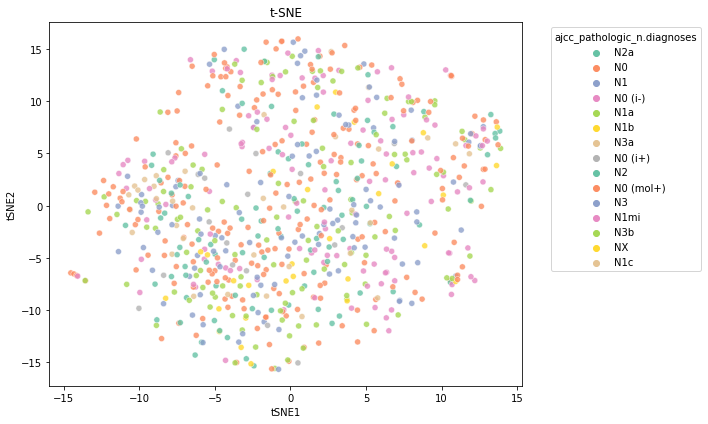

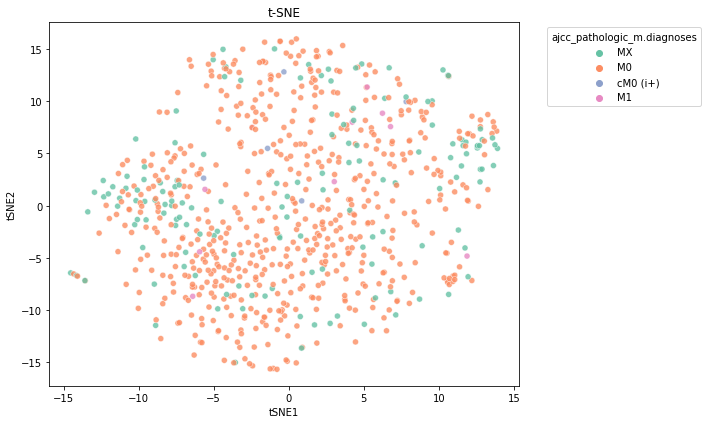

In [11]:
tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'], index=X.index)

def plot_tSNE_by_clinical(tsne_df, clinical_var):
    tsne_df = tsne_df.merge(
    clinical_data[['sample', clinical_var]],
    left_index=True,
    right_on='sample'
    )
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=tsne_df,
        x='tSNE1', y='tSNE2',
        hue=clinical_var,
        palette='Set2',
        alpha=0.8
    )
    plt.title("t-SNE")
    plt.legend(title=clinical_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for v in clinical_vars:
    plot_tSNE_by_clinical(tsne_df, v)



#### UMAP

In [12]:
import umap.umap_ as umap

In [13]:
reducer = umap.UMAP(
    n_neighbors=30,    # try values between 5 and 50
    min_dist=0.1,      # tighter clusters if you lower this
    metric='euclidean',
    random_state=42
)

umap_embedding = reducer.fit_transform(X)

C:\Users\igali\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


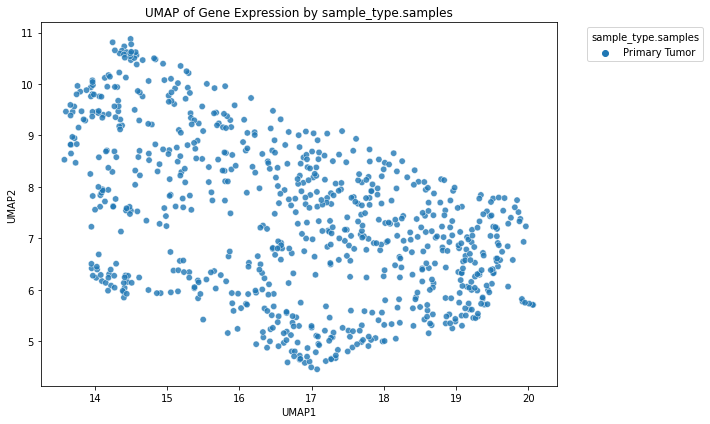

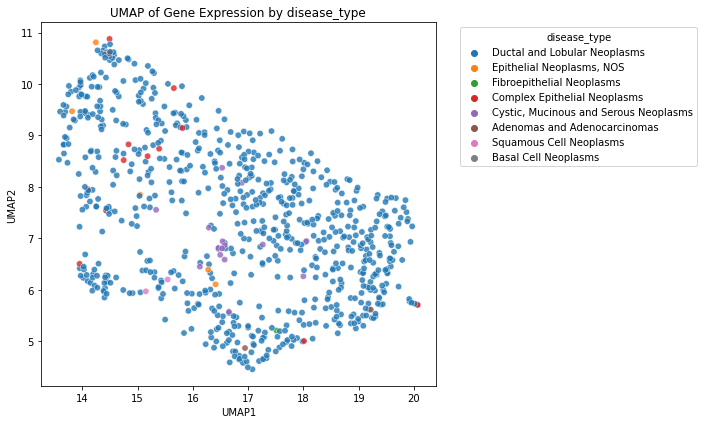

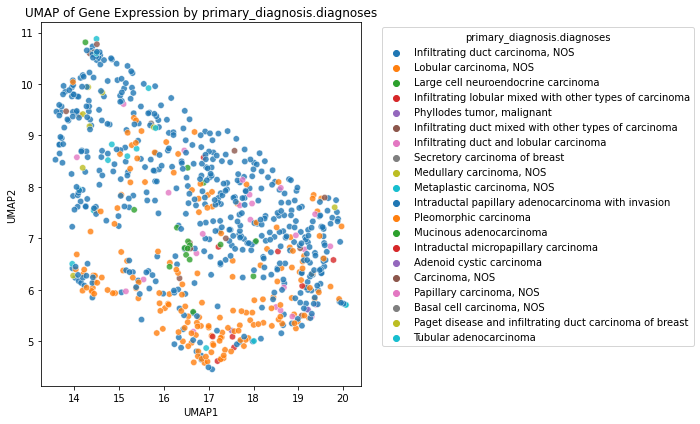

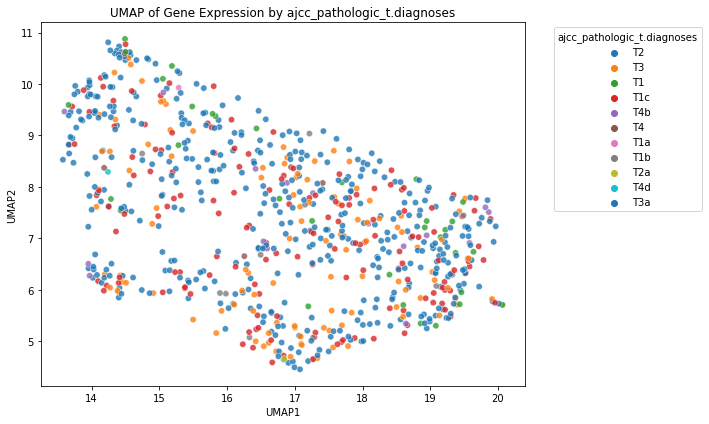

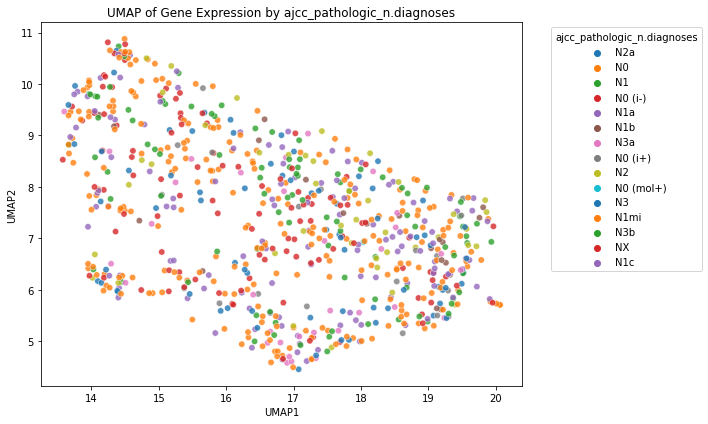

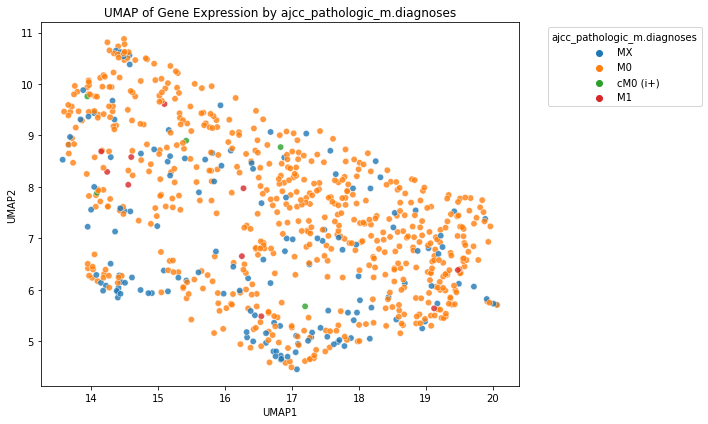

In [14]:
umap_df = pd.DataFrame(
    umap_embedding,
    columns=['UMAP1','UMAP2'],
    index=X.index
).reset_index().rename(columns={'index':'sample'})

def plot_umap_by_clinical(umap_df, clinical_var):
    # Merge with clinical stage labels
    plot_df = umap_df.merge(
        clinical_data[['sample',clinical_var]],
        on='sample', how='inner'
    )
    # Plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue=clinical_var,
        palette='tab10',
        alpha=0.8,
        s=40
    )
    plt.title(f"UMAP of Gene Expression by {clinical_var}")
    plt.legend(title=clinical_var, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

for v in clinical_vars:
    plot_umap_by_clinical(umap_df, v)

In [15]:
clinical_data["ajcc_pathologic_stage.diagnoses"].value_counts()

II        433
III+IV    207
I         126
Name: ajcc_pathologic_stage.diagnoses, dtype: int64

#### Heatmap and hierarchical clustering of top-variable genes

In [16]:
# Compute variance per gene (row)
gene_variances = gene_expression_data.var(axis=1)

# Sort descending and look at top genes
top_500_genes = gene_variances.sort_values(ascending=False).head(500)
print(top_500_genes)

Ensembl_ID
ENSG00000242252    1.250171
ENSG00000227232    1.237533
ENSG00000164404    1.237287
ENSG00000262484    1.236979
ENSG00000099949    1.234579
                     ...   
ENSG00000122545    1.140500
ENSG00000231705    1.140352
ENSG00000268938    1.140226
ENSG00000095951    1.140192
ENSG00000099992    1.140154
Length: 500, dtype: float64


c:\Users\igali\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(756.8749999999999, 0.5, 'Top 500 variable genes')

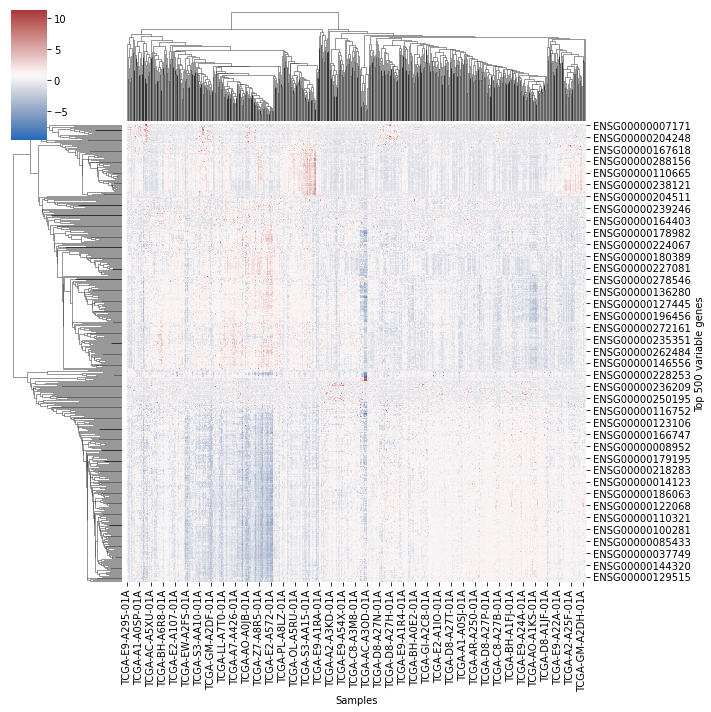

In [17]:
from scipy.cluster.hierarchy import linkage

vars = top_500_genes.index
sub = gene_expression_data.loc[vars]

g = sns.clustermap(sub, metric='correlation', method='average',
                   col_cluster=True, row_cluster=True,
                   cmap='vlag', figsize=(10,10))
g.ax_heatmap.set_xlabel("Samples")
g.ax_heatmap.set_ylabel("Top 500 variable genes")

### Methylation

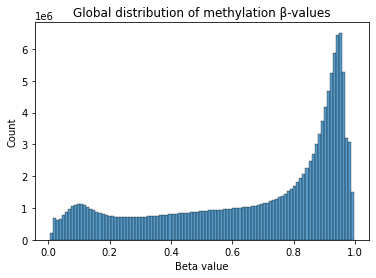

In [18]:
# Plot distribution of Beta-Values

all_vals = methylation_data.values.flatten()
plt.figure(figsize=(6,4))
sns.histplot(all_vals, bins=100, kde=False)
plt.xlabel('Beta value')
plt.ylabel('Count')
plt.title('Global distribution of methylation β-values')
plt.show()

In [19]:
# 1) Prepare data matrix (samples × probes)
X = methylation_data.T  # now rows are samples, cols are probes

#### PCA

In [20]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

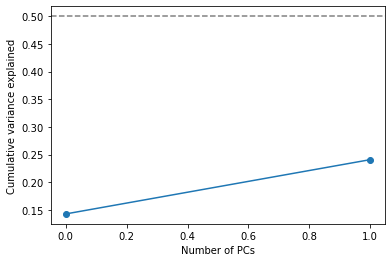

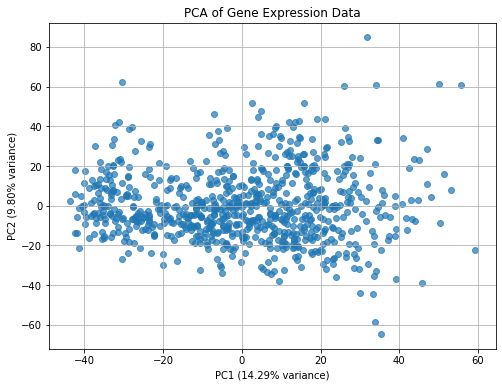

In [21]:
var_ratios = pca.explained_variance_ratio_
plt.plot(np.cumsum(var_ratios), marker='o')
plt.xlabel("Number of PCs"); plt.ylabel("Cumulative variance explained");
plt.axhline(0.5, color='gray', linestyle='--')  # e.g. half the variance
plt.show()

# PCA Visualization
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.title("PCA of Gene Expression Data")
plt.grid(True)
plt.show()

                        PC1        PC2
sample                                
TCGA-AQ-A0Y5-01A   7.044025  -4.441785
TCGA-EW-A2FW-01A  19.663534   8.132179
TCGA-C8-A274-01A  29.867334 -32.026215
TCGA-B6-A0IK-01A  -6.456275 -18.418785
TCGA-E2-A1L7-01A   4.955653 -31.038108
...                     ...        ...
TCGA-E9-A1R2-01A   1.719771 -10.782930
TCGA-E2-A1IG-01A  27.038781  19.563481
TCGA-AR-A2LE-01A  15.705269  20.189819
TCGA-E2-A1IO-01A  -3.851920  10.070754
TCGA-S3-AA11-01A  24.357199 -12.015312

[766 rows x 2 columns]


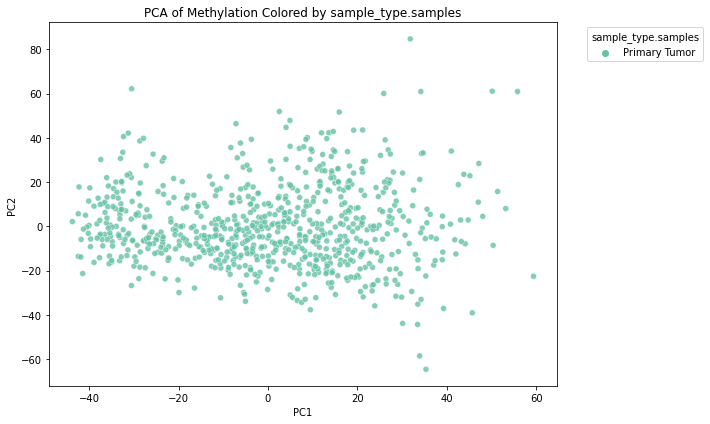

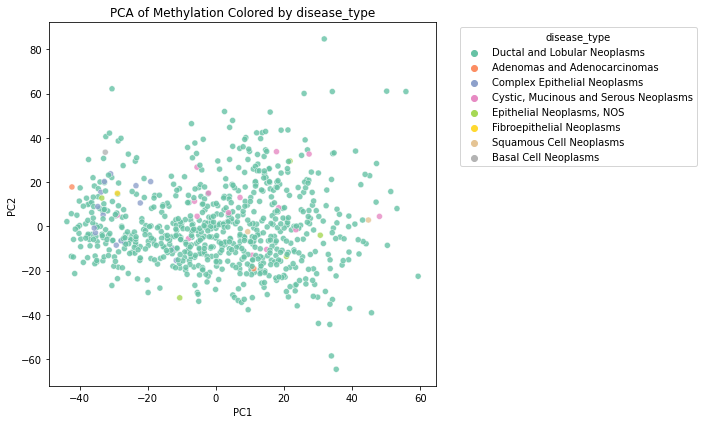

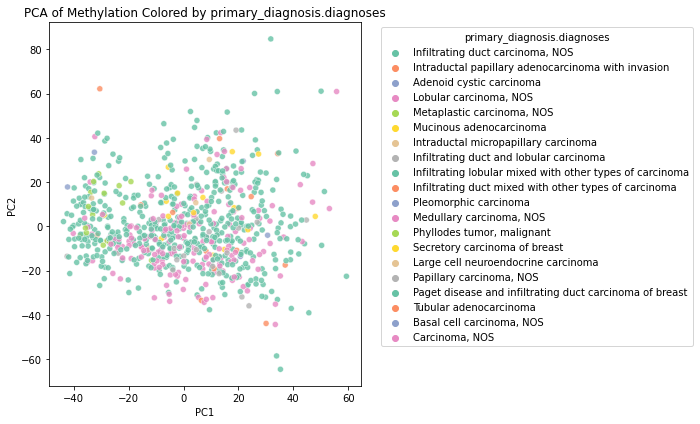

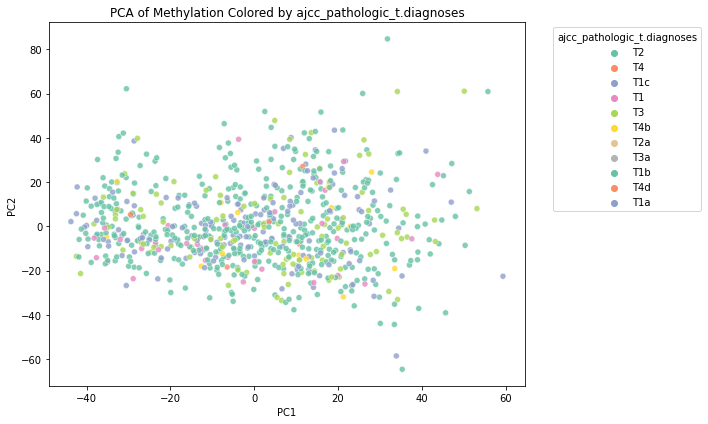

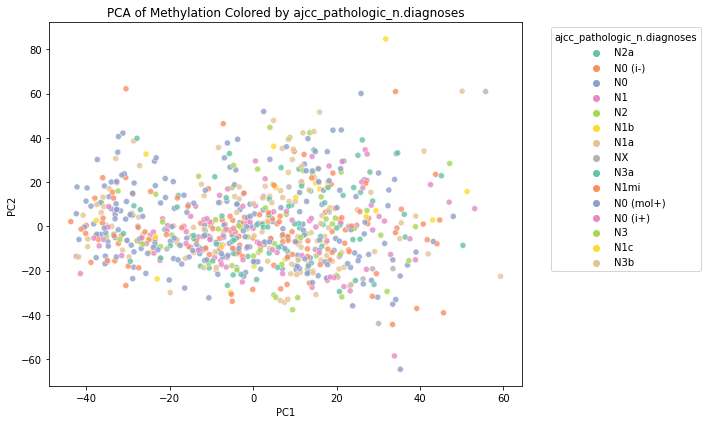

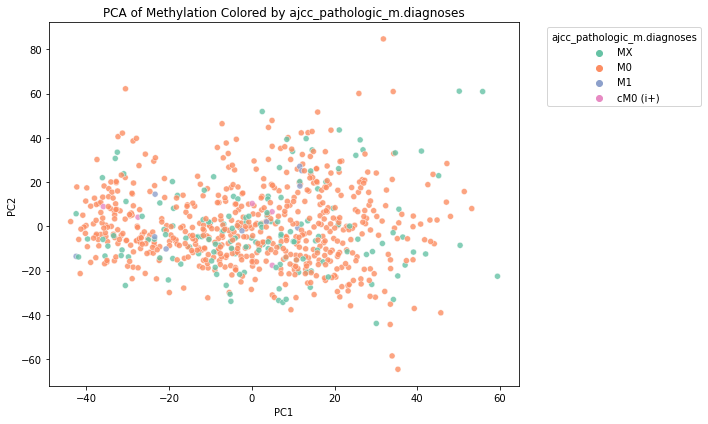

In [22]:

pca_df = pd.DataFrame(pca_result, columns=['PC1','PC2'], index=X.index)
pca_df.index.name = 'sample'
print(pca_df)

def plot_pca_by_clinical_meth(pca_df, clinical_var):
    clinical_data_pca = clinical_data[['sample', clinical_var]].copy()

    # Merge on sample IDs
    pca_merged = pca_df.merge(clinical_data_pca, left_index=True, right_on='sample')
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=pca_merged,
        x='PC1', y='PC2',
        hue=clinical_var,
        palette='Set2',
        alpha=0.8
    )
    plt.title(f'PCA of Methylation Colored by {clinical_var}')
    plt.legend(title=clinical_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for v in clinical_vars:
    plot_pca_by_clinical_meth(pca_df, v)

#### t-SNE

c:\Users\igali\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


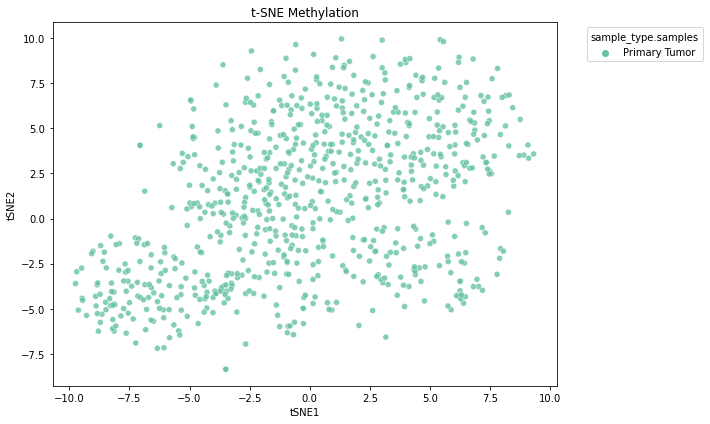

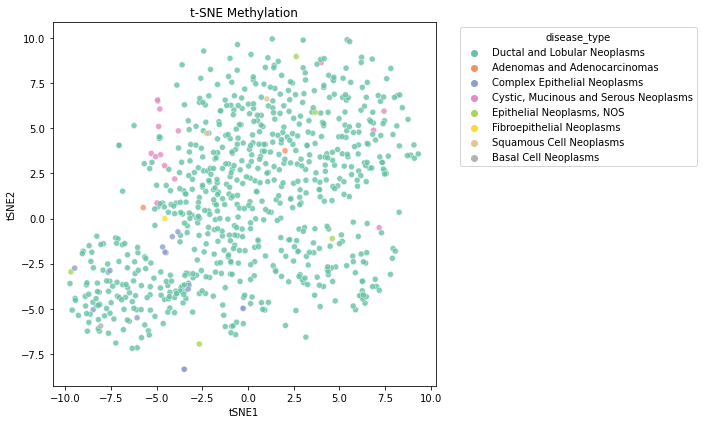

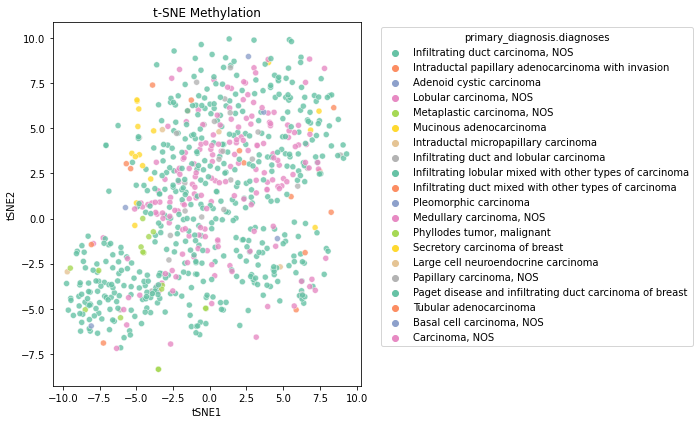

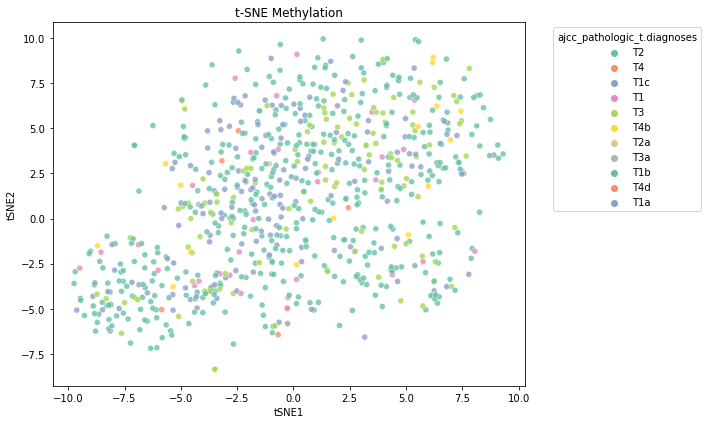

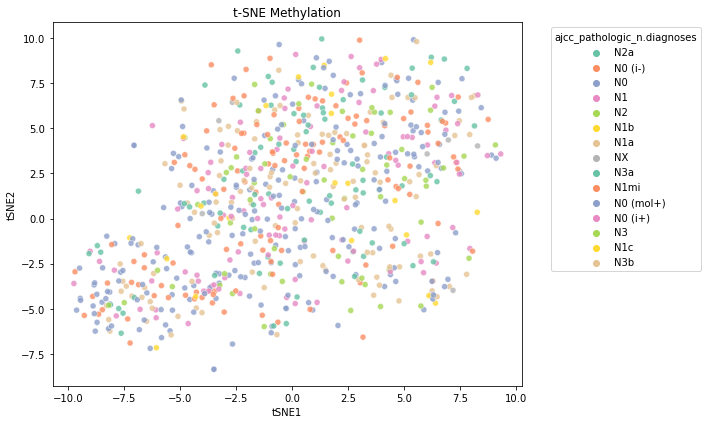

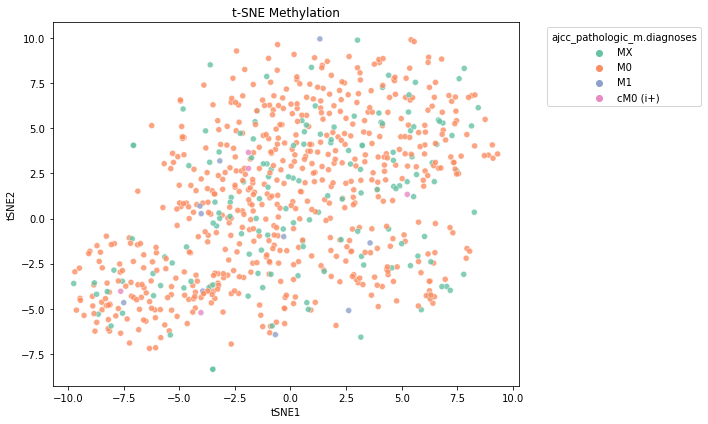

In [23]:

tsne = TSNE(n_components=2, perplexity=60, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(X)
tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1','tSNE2'], index=X.index)
tsne_df.index.name = 'sample'

def plot_tSNE_by_clinical_meth(tsne_df, clinical_var):
    tsne_df = tsne_df.merge(
    clinical_data[['sample', clinical_var]],
    left_index=True,
    right_on='sample'
    )
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=tsne_df,
        x='tSNE1', y='tSNE2',
        hue=clinical_var,
        palette='Set2',
        alpha=0.8
    )
    plt.title("t-SNE Methylation")
    plt.legend(title=clinical_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for v in clinical_vars:
    plot_tSNE_by_clinical_meth(tsne_df, v)



#### UMAP

C:\Users\igali\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


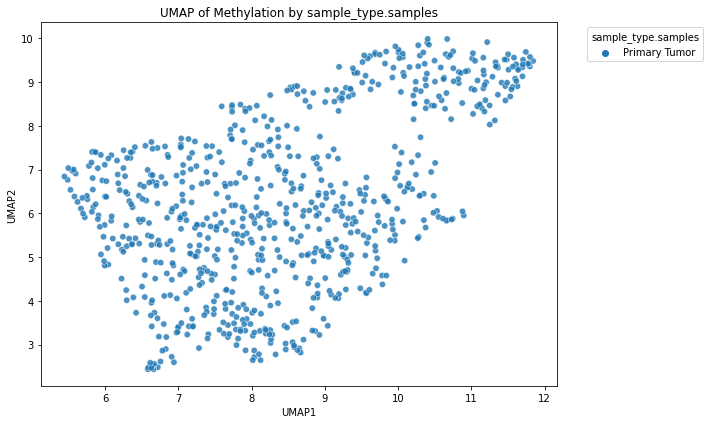

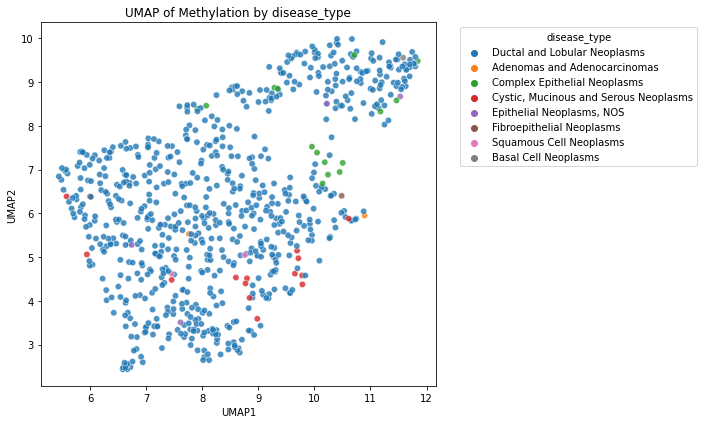

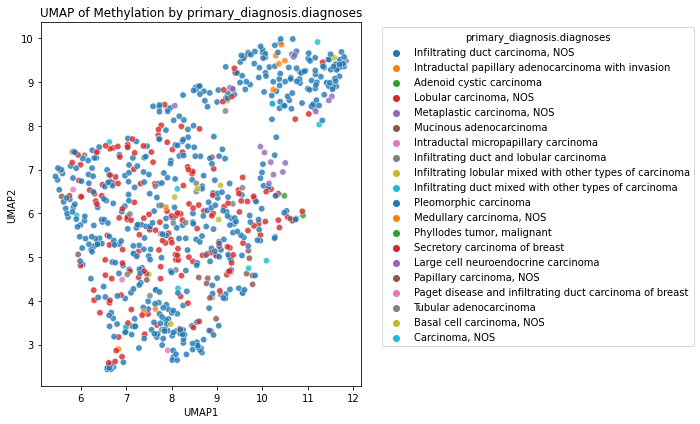

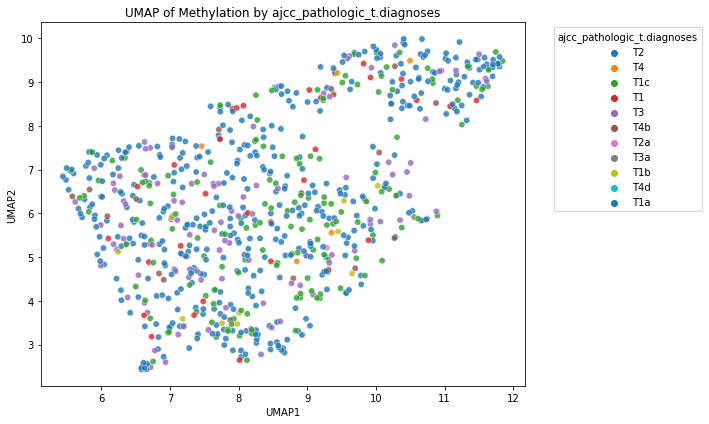

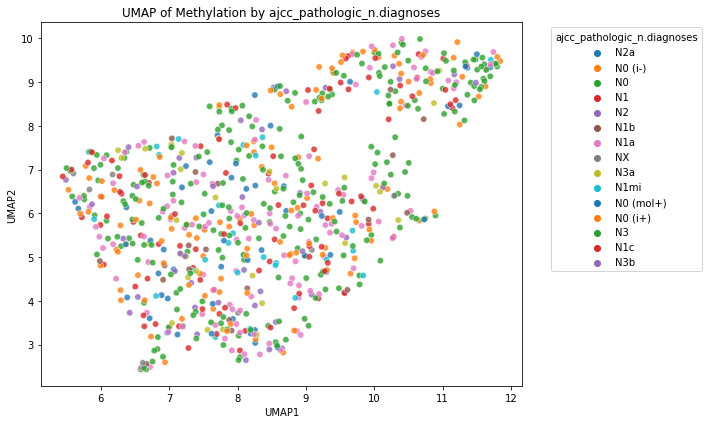

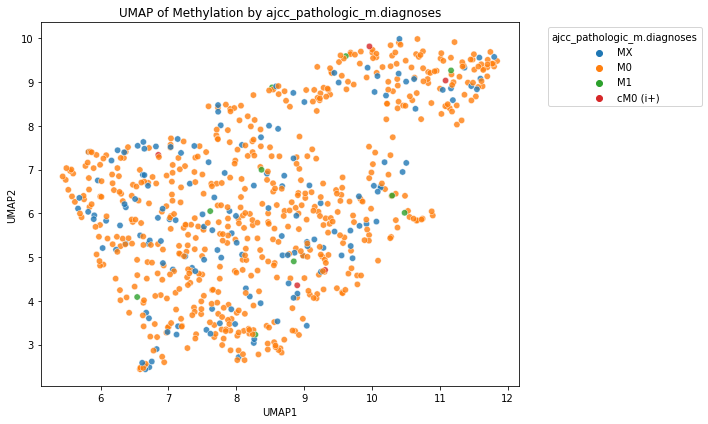

In [24]:
reducer = umap.UMAP(
    n_neighbors=10,    # try values between 5 and 50
    min_dist=0.1,      # tighter clusters if you lower this
    metric='euclidean',
    random_state=42
)

umap_embedding = reducer.fit_transform(X)

umap_df = pd.DataFrame(
    umap_embedding,
    columns=['UMAP1','UMAP2'],
    index=X.index
).reset_index().rename(columns={'index':'sample'})

def plot_umap_by_clinical_meth(umap_df, clinical_var):
    # Merge with clinical stage labels
    plot_df = umap_df.merge(
        clinical_data[['sample',clinical_var]],
        on='sample', how='inner'
    )
    # Plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=plot_df,
        x='UMAP1', y='UMAP2',
        hue=clinical_var,
        palette='tab10',
        alpha=0.8,
        s=40
    )
    plt.title(f"UMAP of Methylation by {clinical_var}")
    plt.legend(title=clinical_var, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

for v in clinical_vars:
    plot_umap_by_clinical_meth(umap_df, v)